# Personal Info

Name: Seyyed Amirmahdi Sadrzadeh

Student Number: 401102015

# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [18]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

## Helper Functioins

In [19]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [20]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [21]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [22]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [23]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Reminder and a sample of training loop

In [ ]:
class emnist_net(nn.Module):


  """
  Neural network instance with following structure
  # Convolutional Layer 1: 1 --> 32, kernel_size=5, padding=2 + maxpooling
  # Convolutional Block 2: 32 --> 64, kernel_size=5, padding=2 + maxpooling
  # Fully Connected Layer 1: 3136 --> 128
  # Fully Connected Layer 2: 128 --> 2
  """


  def __init__(self):
    """
    Initialise parameters of sample network

    Args:
      None

    Returns:
      Nothing
    """
    super().__init__()

    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure

    # comment the line below to test your code
    # raise NotImplementedError("Define the required layers")
    ####################################################################

    # 1)
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=1)
    self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After two max pools, image size is reduced from 28x28 to 7x7
    self.fc2 = nn.Linear(128, 26)


  def forward(self, x):
    """
    Forward pass of sample network

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through sample network
    """

    ####################################################################
    # TODO:
    # 2) Define forward pass for any input x (don't forget relus)

    # comment the line below to test your code
    # raise NotImplementedError("Define forward pass for any input x")
    ####################################################################

    # 2)

    # Conv layer 1.
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2) # another way to implement maxpooling

    # Conv layer 2.
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Fully connected layer 1.
    x = x.view(-1, 7 * 7 * 64)  # another way to flatten the output
    x = self.fc1(x)
    x = F.relu(x)

    # Fully connected layer 2.
    x = self.fc2(x)

    return x

In [ ]:
# Download the data

fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

mnist_train = datasets.EMNIST(root=".",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False,
                              split='letters')
mnist_test = datasets.EMNIST(root=".",
                             train=False,
                             transform=transforms.ToTensor(),
                             download=False,
                             split='letters')

# Labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# Create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)

In [17]:
# Training

model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Iterate through train set minibatchs
for epoch in trange(3):
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    x = images

    # Move the data to GPU for faster execution
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss
    loss = criterion(y, labs)

    # Backpropagation and gradient update
    loss.backward() # Calculate gradients
    optimizer.step() # Apply gradient udpate


# Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct / total * 100:.2f}%')

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Download Fashion MNIST dataset

* The dataset we are going to use consists of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 gray scale image, associated with a label from 10 classes.

* Reducing the dataset to just the two categories (T-shirt/top and Shirt) reduces the training time to about 2 minutes.

In [ ]:
# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)




Extracting the files...



In [ ]:
# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing Fashion-MNIST Data to two-categories:
    T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

Visualize the data

In [ ]:
#num_classes = 10
#train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

# Example of reducing the data into 2 categories
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 1404 has been set.


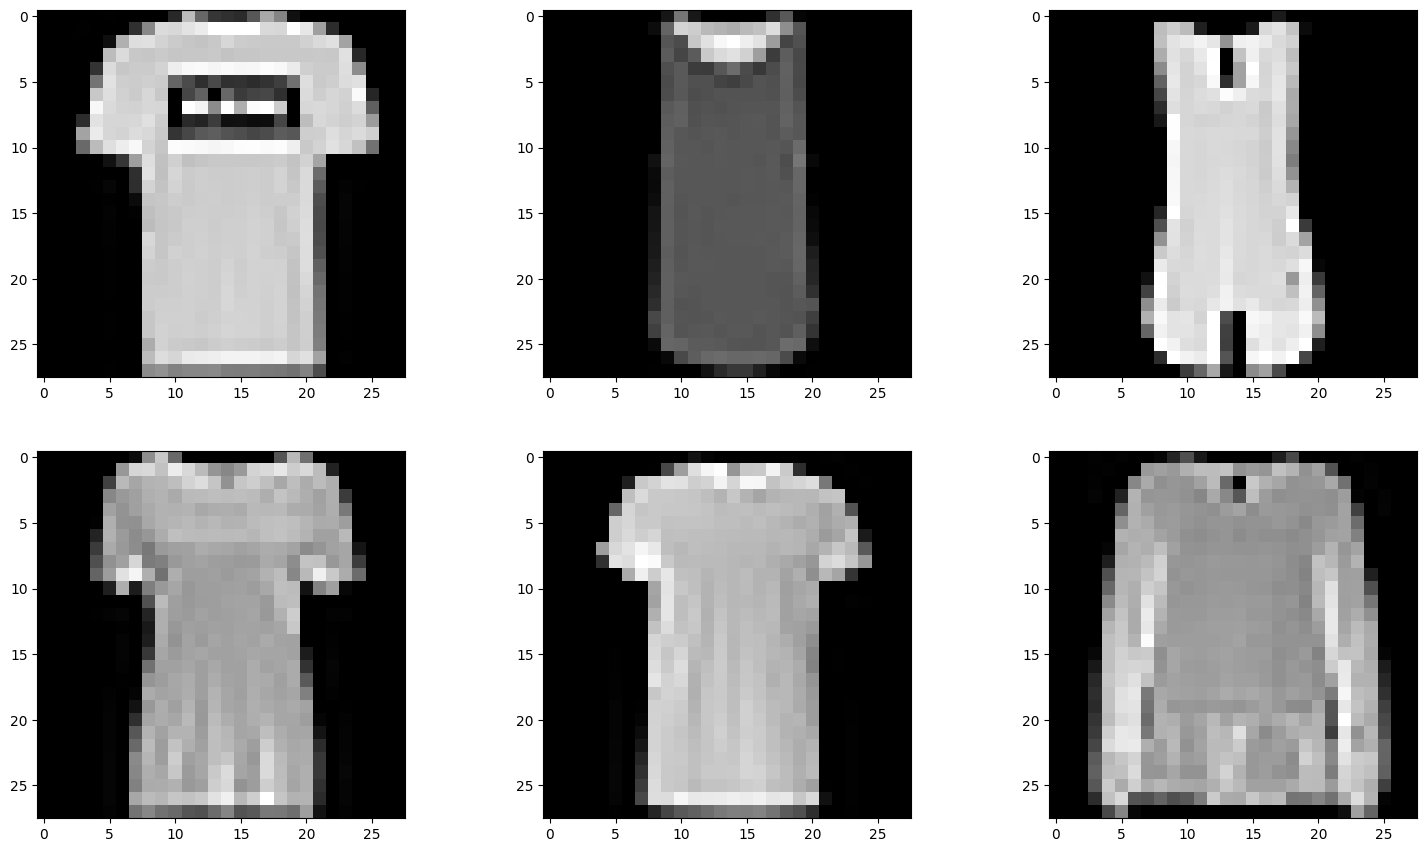

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax5.imshow(train_data[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax6.imshow(train_data[5][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

# Getting the DataLoaders

In [ ]:
# It's good to take a better look at this section so that you also learn to define DataLoaders yourself

def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

# Code the training loop

You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN.

* Choose the correct criterion

* Code the training part (calculating gradients, loss, stepping forward)

* Keep a track of the running loss

In [ ]:
class FMNIST_Net1(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 86.5%


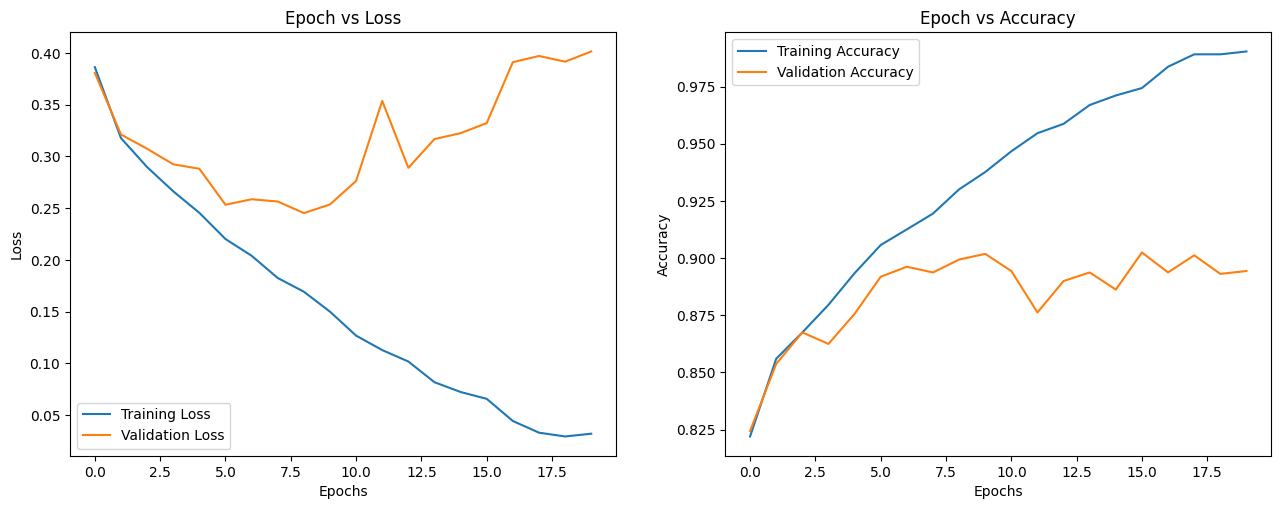

In [ ]:
def train(model, device, train_loader, validation_loader, epochs):
  """
  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set
    validation_loader: torch.loader
      Validation set

  Returns:
    Nothing
  """


  ####################################################################
  # TODO:
  # Code the training loop by following the steps

  # comment the line below to test your code
  raise NotImplementedError("Update the steps of the train loop")
  ####################################################################

  # 1) set the criterion to CrossEntropyLoss
  criterion =  ...

  # 2) set the optimizer to SGD --> lr=0.01, momentum=0.9
  optimizer = ...

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # Keeps track of the running loss
      running_loss = 0.
      correct, total = 0, 0
      for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        # 3) Get the model output
        output = ...

        # 4) Zero the gradients out
        ...

        # 5) Get the Loss
        loss = ... # --> call the loss criterion with the model's output and the target values

        # 6) Calculate the gradients
        ...

        # 7) Update the weights
        ...

        # 8) Set loss to whatever you end up naming your variable when calling criterion
        # then set loss = loss.item() in the set_postfix function
        tepochs.set_postfix(...)

        # 9) Add the loss for this batch
        running_loss += ...

        # Get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # 10) Append the loss for this epoch (running loss divided by the number of batches)
      # hint --> you can number of batches from train_loader
      train_loss.append(...)
      train_acc.append(correct / total)

      # 11) complete according to above
      # Evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0
      for data, target in validation_loader:
        data, target = data.to(device), target.to(device)

        # Zero the gradients out
        ...

        # Get the model output
        output = ...

        # Get the Loss
        loss = ...

        # complete as above
        tepochs.set_postfix(...)
        running_loss += ...

        # Get accuracy
        _, predicted = ...
        total += ...
        correct += (...).sum().item()

      validation_loss.append(...)
      validation_acc.append(...)

  return train_loss, train_acc, validation_loss, validation_acc


set_seed(SEED)
## Uncomment to test your training loop
net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q1: Do you think this network is overfitting? If so, what ways do you recommend to face this problem?**

# Confronting Overfitting

## Reugulariztion

* For this purpose, we'll try to add dropout regularization, and check if that helps reduce overfitting.

* You'll be asked to try different regularization methods other that dropout.

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 87.75%


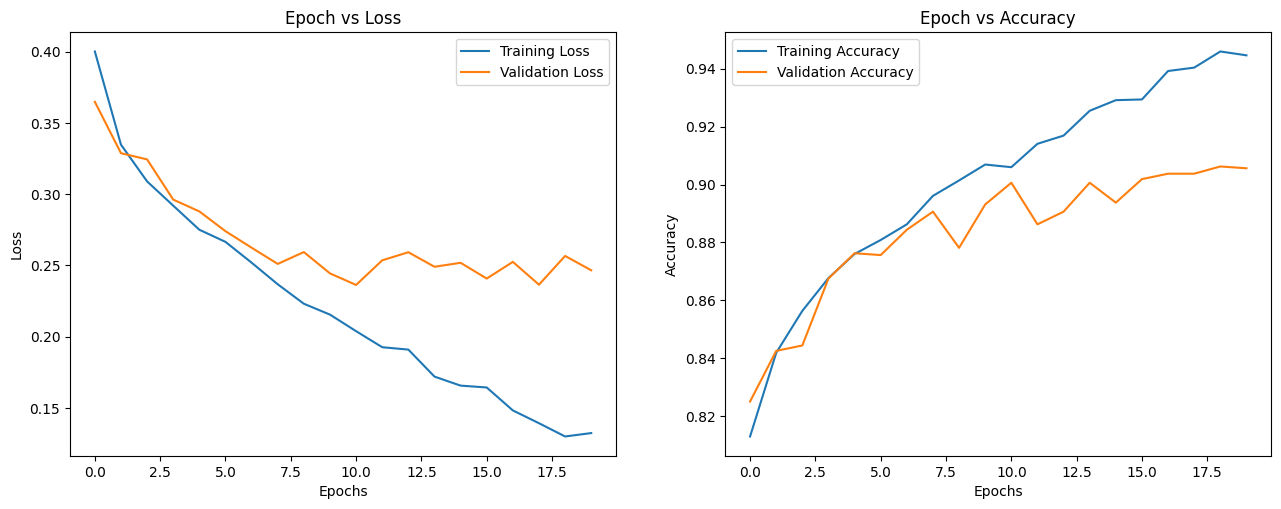

In [ ]:
class FMNIST_Net2(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of FMNIST_Net2

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net2, self).__init__()


    ####################################################################
    # TODO:
    # 1) Add dropout layers (set the dropout1 parameter to 0.5 and dropout2 to 0.25)

    # comment the line below to test your code
    raise NotImplementedError("Add regularization layers")
    ####################################################################


    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    # 1)
    self.dropout1 = ...
    self.dropout2 = ...
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """
    Forward pass of FMNIST_Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through FMNIST_Net2
    """

    ####################################################################
    # TODO:
    # 2) Add the layers in your forward pass in appropriate order

    # comment the line below to test your code
    raise NotImplementedError("Add regularization layers")
    ####################################################################

    # 2)
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = ...
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = ...
    x = self.fc2(x)
    return x


set_seed(SEED)

net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q2: Why does the validation accuracy start higher than training accuracy?**

In [ ]:
# Define a CNN instance similar to the one above and add different regularization methods to it

# YOUR CODE

## Data Augmentation

Now, Let's add data augmentation to the model via transforms and see if that helps it generalize better.

* Add the transforms you want in the list `augmentation_transforms`.

* Run the same network you created in the above exercise (with regularization) and plot the loss and accuracies.



> [Here](https://pytorch.org/vision/stable/transforms.html) is the link to the list of transforms available in PyTorch.



In [ ]:
def transforms_custom(binary=False, download=False, seed=0):
  """
  Helper function defining transformations

  Args:
    binary: boolean
      If True, number of classes = 2
    download: boolean
      If True, download dataset
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Set
    test_loader: torch.loader
      Test Set
    validation_loader: torch.loader
      Validation Set
  """
  # Basic preprocessing
  preprocessing_transforms = [transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))]
  # Add the augmentation transforms to the preprocessing
  train_transform = transforms.Compose(get_augmentation_transforms() +
                                       preprocessing_transforms)
  # Load the Fashion MNIST dataset with the transforms
  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=train_transform)
  if binary:
    # Reduce to our two classes to speed up training
    train_data = reduce_classes(train_data)

  # Get the data loader instances for the dataset
  train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                  validation_data,
                                                                  test_data,
                                                                  seed)

  return train_loader, validation_loader, test_loader

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 86.25%


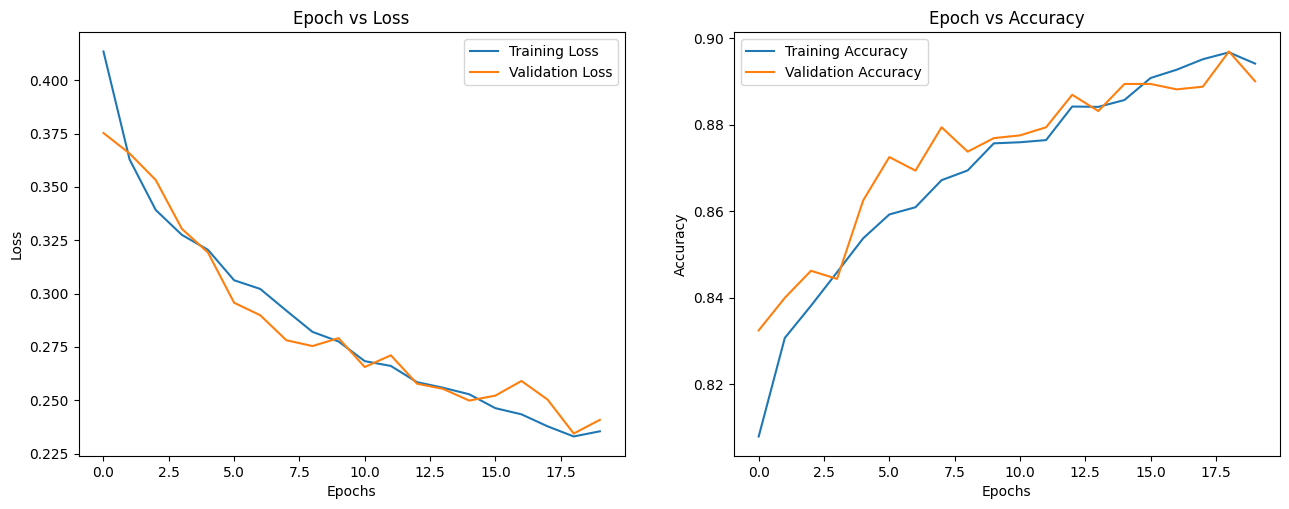

In [ ]:
def get_augmentation_transforms():
  """
  Returns Augmentation Transforms

  Args:
    None

  Returns:
    augmentation_transforms: list
      List of augmentation transforms
  """

  ####################################################################
  # TODO:
  # 1) Add transforms

  # comment the line below to test your code
  raise NotImplementedError("Add transforms")
  ####################################################################

  # 1)
  augmentation_transforms = [..., ...]

  return augmentation_transforms


set_seed(SEED)
net3 = FMNIST_Net2(num_classes=2).to(DEVICE)  # Get the network

train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q3: Did the training accuracy reduce further compared to dropout alone? Is the model still overfitting?**

# Further Tasks

## Task 1: BatchNorm Experiment

Replace the dropout layers with `BatchNorm2d` layers. Compare performance, overfitting behavior, and convergence speed.

**Q: which should be applied first if implementing both in a CNN? why?**

In [ ]:
# YOUR CODE HERE

## Task 2: Early Stopping

Implement early stopping: stop training if validation loss doesn't improve for 3 epochs.

**Q: How does this help preventing overfitting and saving computational cost?**

In [ ]:
# YOUR CODE HERE

## Task 3: Try New Augmentations

Experiment with different augmentation strategies. How do they impact training?”

In [ ]:
# YOUR CODE HERE

## Task 4: Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

In [ ]:
# YOUR CODE HERE